In [5]:
import torch
from utils import fetch_words
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# architecture
# input word (one-hot encoded), plucks out one row from lookup table
# C - input (17,000 x 30) - hence we have 90 neurons in total on that layer (30 per word) (matrix C shared across words)
# 1 hidden layer (hyperpameter size), let's say 100 neurons
# 1 output layer (17,000 neurons) - each neuron corresponds to one word in the vocabulary
# softmax to get probabilities
# loss function - negative log likelihood (NLL) of the correct word

In [7]:
words = fetch_words()
print(words[:8], len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'] 32033


In [11]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [160]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X,Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [161]:
#print(X.shape, Y.shape)
print(X.shape, Y.shape)

torch.Size([228146, 3]) torch.Size([228146])


In [38]:
# X,Y = [], []
# for w in words[:2]:
#     print(f'{w}')
#     context_char = ['.','.','.']
#     for char in w + '.': # :[.]
#         print(f'{context_char} -> {char}')
#         target_idx = stoi[char]
#         Y.append(target_idx)

#         context_char.pop(0)
#         context_char.append(char)
#         # convert context into indices
#         context_idx = [stoi[i] for i in context_char]
#         X.append(context_idx)
        
# print(torch.tensor(X))
# print(Y)


In [255]:
# let's build lookup table C
g = torch.Generator().manual_seed(2147483647)
embedding_dim = 10
hidden_size = 200
C = torch.randn((vocab_size, embedding_dim), generator=g) # 30 is embedding dimension
W1 = torch.randn((embedding_dim * 3, hidden_size), generator=g) # 100 is hidden layer size
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn((hidden_size, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

11897


In [256]:
for p in parameters:
    p.requires_grad = True

In [257]:
# # forward pass
# for i in range(10):
#     emb = C[X] # (32, 3, 2)
#     h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
#     logits = h @ W2 + b2 # (32, 27)
#     loss = F.cross_entropy(logits, Y) # softmax + NLL
#     print(f'{loss.item()=}')
#     # backward pass
#     for p in [C, W1, b1, W2, b2]:
#         p.grad = None

#     loss.backward()

#     with torch.no_grad():
#         for p in parameters:
#             p -= 0.1 * p.grad



In [258]:
# it's too much work to train all the data at once, let's do mini-batches

In [259]:
batch_size = 32 # how many examples to process at once
indices = torch.randint(0, X.shape[0], (batch_size,), generator=g)
indices

tensor([155794,  98351, 143565,  34952, 162511, 198043, 109692, 203804, 109755,
         13475, 211616, 141736, 228099, 126123, 101296, 192371, 227495,   6697,
         93427,  52957, 174545, 151038,  85910,  23906,  68804,  92553,   5938,
        218031,  80304, 158526, 151283,  46793])

In [260]:
# lets find the optimal learning rate
# it's somewhere between (1e-3, 1) -> use exponentially spaced learning rates rates
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [261]:
lossi = []
lri = []
stepi = []

In [266]:
# with mini-batches
# with learning rates

for i in range(50000):
    indices = torch.randint(0, X.shape[0], (batch_size,), generator=g)
    emb = C[X[indices]] # (batch_size, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[indices]) # softmax + NLL
    
    if i % 10000 == 0:
        print(f'{loss.item()=}')
    # backward pass
    for p in [C, W1, b1, W2, b2]:
        p.grad = None

    loss.backward()
    lr = 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad
    
    # track stats
    lossi.append(loss.log10().item())
    lri.append(lr)
    stepi.append(i)



loss.item()=2.4567337036132812
loss.item()=2.1912169456481934
loss.item()=2.4038631916046143
loss.item()=2.0585358142852783
loss.item()=2.257931709289551


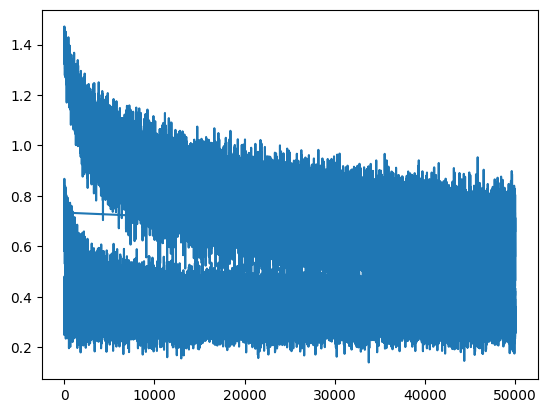

In [267]:
plt.plot(stepi, lossi)

In [ ]:
# real loss
def calc_loss(Xi, Yi):
    emb = C[Xi] # (batch_size, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yi) # softmax + NLL
    print(f'loss = {loss.item()}') # 2.3 already better than bigram model

#calc_loss(X, Y)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (912900x6 and 30x200)

In [217]:
# split into train/val/test
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [218]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [237]:

for i in range(10000):
    indices = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    emb = C[Xtr[indices]] # (batch_size, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[indices]) # softmax + NLL
    
    if i % 1000 == 0:
        print(f'{loss.item()=}')
    # backward pass
    for p in [C, W1, b1, W2, b2]:
        p.grad = None

    loss.backward()
    lr = 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad

loss.item()=2.2699785232543945
loss.item()=2.4324028491973877
loss.item()=2.3797402381896973
loss.item()=2.2228283882141113
loss.item()=2.366102695465088
loss.item()=2.2114617824554443
loss.item()=2.025968313217163
loss.item()=2.2997522354125977
loss.item()=2.4074697494506836
loss.item()=2.046900749206543


In [238]:
calc_loss(Xtr, Ytr)
calc_loss(Xdev, Ydev)
calc_loss(Xte, Yte)

loss = 2.282076835632324
loss = 2.292693614959717
loss = 2.2929234504699707


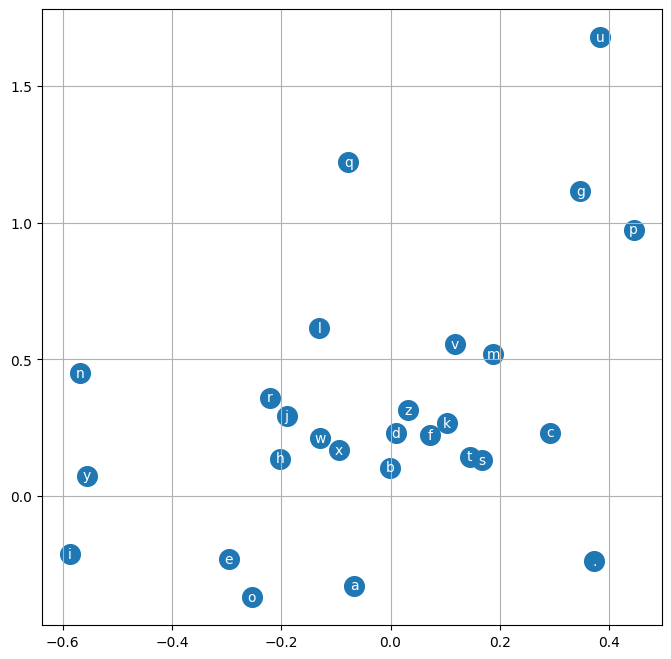

In [239]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [269]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amoriq.
khiwmyn.
jehty.
skandene.
mahnen.
amerynci.
aqei.
nelonia.
chaiir.
kaleigh.
ham.
join.
quintis.
lilea.
jadiquinterogdiarynix.
kaeunitsan.
edde.
oia.
gilee.
